# Product Category Classification

In this notebook, we will try to predict a cosmetic product's category just using ingredient related features. We can identify representive ingredients for different categories, and find categories that are similar in their formula.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import itertools

import sys
sys.path.append('../utilities')
from data_utils import *
from ml_utils import *

### Prepare data

We will use categories that have at least 100 products with ingredient info. As one product may belong to more than one category, we will do a multi-label classification.

In [2]:
# read cleaned data
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

# merge skin-care, body-care and makeup table
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)

# drop products without ingredient info
df = df.loc[~df['ingredient'].isnull()]

# pick large categories, with more than 100 products
large_categories = ['Nighttime Moisturizer', 'Cleansers', 'Serum','Exfoliants', 
                    'Eye Cream & Treatment', 'Daytime Moisturizer',
                    'Sunscreen', 'Toner & Face Mist', 'Face Mask',
                    'Acne & Blemish Treatment', 'Scrub', 'Lip Balm',
                    'Body Lotion', 'Foundation', 'Lip Stick/Gloss/Liner', 
                    'Foundation Primer', 'Face Powder']
df = df.loc[df['product_category'].isin(large_categories)]

# merge same product rows and combine categories into set
product_category_set = df.groupby(['product_names','brand'])['product_category'].apply(set)
df = df.groupby(['product_names','brand']).first()
df['product_category'] = product_category_set
df = df.reset_index()
df.head()

,product_names,brand,product_category,ingredient,size,price,size_num,size_unit,avg_price,active_ingredient,...,active_cat_count_Texture Enhancer,active_cat_count_Thickeners/Emulsifiers,active_cat_count_Uncategorized,active_cat_count_Vitamins,active_mean_rating,inactive_mean_rating,inactive_mean_rating_w1,inactive_mean_rating_w2,active_cat_count_Absorbent,active_cat_count_Emulsifiers
0,1% Retinol Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Glycereth-7 Triacetate (emollien...",0.50 fl. oz.,52.0,15.0,ml,3.466667,NaN,...,0.0,0.0,0.0,0.0,NaN,2.172414,2.170828,2.145176,NaN,NaN
1,10 HR Wear Perfection Foundation,Sephora,{Foundation},"Water, Dimethicone, CI77891 (Titanium Dioxide)...",NaN,20.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,NaN,2.034483,2.062283,2.046158,0.0,0.0
2,10% Glycolic Solutions Moisturizer,Peter Thomas Roth,{Exfoliants},"Water, Water/Aqua/Eau, Glycolic Acid, Glycerin...",2.20 fl. oz.,45.0,65.0,ml,0.692308,NaN,...,0.0,0.0,0.0,0.0,NaN,2.310345,2.267128,2.320281,NaN,NaN
3,10% Niacinamide Booster,Paula's Choice Skincare,{Serum},"Water (Aqua), Niacinamide (vitamin B3, skin-re...",0.67 fl. oz.,42.0,20.0,ml,2.100000,NaN,...,0.0,0.0,0.0,0.0,NaN,2.500000,2.506232,2.615566,NaN,NaN
4,100% Mineral Sunscreen Mist SPF 30,Supergoop!,{Sunscreen},Active: Zinc Oxide (12%). Other: Aloe Barbaden...,6.00 fl. oz.,34.0,177.0,ml,0.192090,Zinc Oxide (12%).,...,0.0,1.0,0.0,0.0,3.0,2.210526,2.210526,2.210526,NaN,NaN


#### Count ingredients

Create binary ingredient count. The feature matrix will be N_product * N_ingredients, with 0 or 1 indicate whether certain ingredient exists in a product. These binary-valued features are suitable for Bernoulli Naive Bayes classification.

In [3]:
ingredient_count_df = get_matching_ingredient_count(df)
ingredient_count_df.head()

,Phyllanthus emblica fruit extract,Cinnamomum camphora,anthocyanin,cyclopentasiloxane,Prunus domestica seed oil,Anacyclus pyrethrum,Gossypium herbacuem seed oil,benzothonium chloride,Simmondsia chinensis,octisalate,...,black locust extract,polysorbate 20,cucumber extract,Ext. D&C,stearates,Prunus serotina (wild cherry) fruit extract,sclareolide,ferric ammonium ferrocyanide,Prunus domestica seed extract,Fucus vesiculosus extract
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training

* Label product categories
* Split train and test set
* Do one vs rest multi-label classification

We will use naive bayes to take care of count features. There are also some general ingredient features that could potentially be useful, such as number of ingredients. We will make use of these features though model stacking: the naive bayes models will serve as first layer models, then the predicted probabilities can be joined with general ingredient features to feed in the final model.
The training pipeline is as follows:

![flow_chart](../documents/images/product_category_flow_chart.png)

In [4]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['product_category'])

df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(df, ingredient_count_df, y, 
                                                                       test_size=0.20, random_state=777)

fold = KFold(5, random_state=777)

### Bernoulli naive bayes for binary ingredient features.

In [5]:
bNB = BernoulliNB()
model = OneVsRestClassifier(bNB)

# get oof predictions on training set
y_train_pred_bNB, y_train_pred_proba_bNB = oof_preds(X_train.values, y_train, model, fold)

# train on the whole training set and predict for test set
model.fit(X_train, y_train)
y_test_pred_bNB = model.predict(X_test)
y_test_pred_proba_bNB = model.predict_proba(X_test)

#### Define some metric for multi-label classification
* multilable confusion matrix
* hamming score

These functions are defined in utils/ml_utils.py. Try on a simple case:

In [6]:
# simple test
y_true = np.array([[0,1,0,1],
                   [0,1,1,0],
                   [1,0,1,0],
                   [0,0,1,1]])

y_pred = np.array([[0,1,1,0],
                   [0,1,1,0],
                   [0,1,1,1],
                   [0,0,0,1]])

mean_hamming, hamming_list = hamming_score(y_true, y_pred, score_by_sample=True)
print("hamming score:", mean_hamming, hamming_list)
multilable_confusion_matrix(y_true, y_pred)

hamming score: 0.5208333333333333 [0.3333333333333333, 1.0, 0.25, 0.5]


predicted class,0,1,2,3
true class,,,,
0,0,1,0,1
1,0,2,1,0
2,0,1,2,1
3,0,0,1,1


#### Evaluate predictions

In [7]:
train_score = hamming_score(y_train, y_train_pred_bNB)
test_score = hamming_score(y_test, y_test_pred_bNB)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

train_confmat = multilable_confusion_matrix(y_train, y_train_pred_bNB, mlb.classes_)
test_confmat = multilable_confusion_matrix(y_test, y_test_pred_bNB, mlb.classes_)

Hamming score: (train)0.3724, (test)0.3588


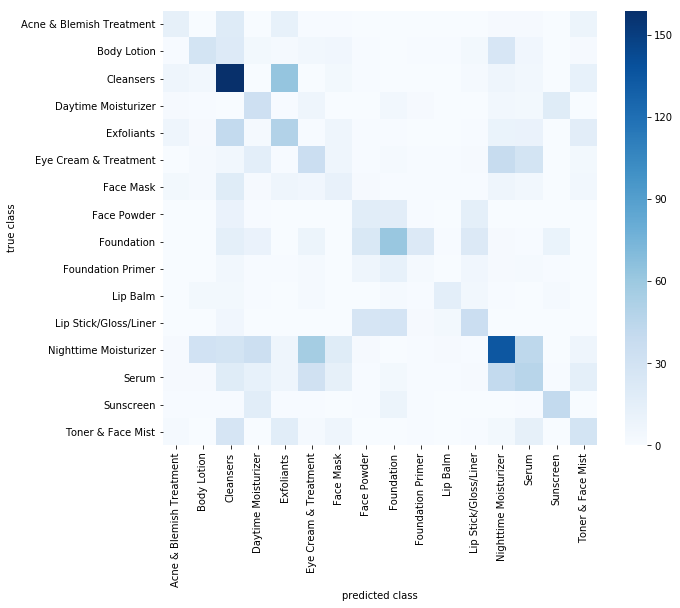

In [8]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(test_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

#### More analysis for each category
* Accuracy
* Most Common miss-predictions
* Area under Curve (auc) score
* Most predictive ingredients for each category

In [9]:
for i, (idx, row) in enumerate(test_confmat.iterrows()):
    accuracy = row[idx] / y_test[:,i].sum()
    print ("true class:", idx)
    print ("accuracy: %.3f"%accuracy)
    confused_class = row.sort_values(ascending=False).drop(idx).iloc[:3].index.values
    print ("top miss predictions:", confused_class, '\n')

true class: Acne & Blemish Treatment
accuracy: 0.400
top miss predictions: ['Cleansers' 'Exfoliants' 'Toner & Face Mist'] 

true class: Body Lotion
accuracy: 0.475
top miss predictions: ['Nighttime Moisturizer' 'Cleansers' 'Serum'] 

true class: Cleansers
accuracy: 0.909
top miss predictions: ['Exfoliants' 'Toner & Face Mist' 'Nighttime Moisturizer'] 

true class: Daytime Moisturizer
accuracy: 0.660
top miss predictions: ['Sunscreen' 'Eye Cream & Treatment' 'Nighttime Moisturizer'] 

true class: Exfoliants
accuracy: 0.532
top miss predictions: ['Cleansers' 'Toner & Face Mist' 'Serum'] 

true class: Eye Cream & Treatment
accuracy: 0.409
top miss predictions: ['Nighttime Moisturizer' 'Serum' 'Daytime Moisturizer'] 

true class: Face Mask
accuracy: 0.279
top miss predictions: ['Cleansers' 'Nighttime Moisturizer' 'Exfoliants'] 

true class: Face Powder
accuracy: 0.818
top miss predictions: ['Foundation' 'Lip Stick/Gloss/Liner' 'Cleansers'] 

true class: Foundation
accuracy: 0.925
top miss 

Plot the "Receiver operating characteristic" (ROC) curves and report auc for each class.

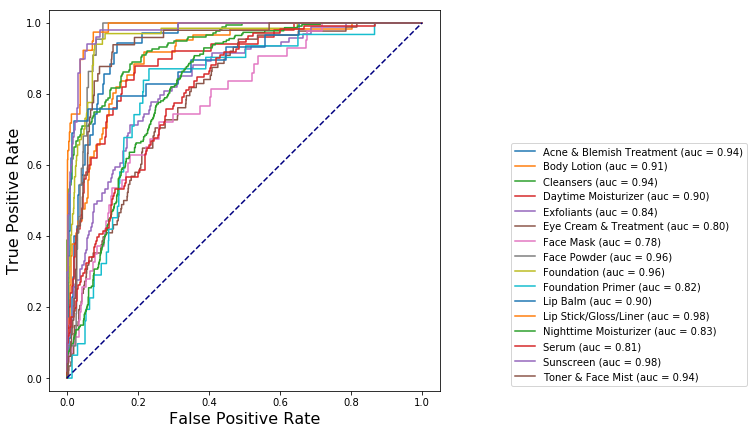

In [10]:
auc_bNB = report_auc_by_class(y_test, y_test_pred_proba_bNB, mlb.classes_)

Make a prediction for each individual ingredient, for each category, find the top 10 ingredients that give highest probability. We do see some ingredients that make sense, for example:

* **Acne Treatment products**: benzoyl peroxide, BHA
* **Cleansers**: solium xxx (sodium salt of fatty acids)
* **Exfoliants**: AHA, BHA
* **Lipsticks**: Coloring Agents/Pigments
* **Sunscreens**: octocrylene, homosalate... (common sunscreen agents)

In [11]:
n_ingredients = ingredient_count_df.shape[1]
X_ingredients = np.eye(n_ingredients,n_ingredients)
y_ingredients = model.predict_proba(X_ingredients)

most_relevant_ingredients = pd.DataFrame()
for i in range(len(mlb.classes_)):
    ind = np.argsort(y_ingredients[:,i])
    top10 = np.flipud(ingredient_count_df.columns.values[ind[-10:]])
    most_relevant_ingredients[mlb.classes_[i]] = top10
    
most_relevant_ingredients

,Acne & Blemish Treatment,Body Lotion,Cleansers,Daytime Moisturizer,Exfoliants,Eye Cream & Treatment,Face Mask,Face Powder,Foundation,Foundation Primer,Lip Balm,Lip Stick/Gloss/Liner,Nighttime Moisturizer,Serum,Sunscreen,Toner & Face Mist
0,advanced glycation endproduct (AGE),Larrea tridentata,sodium palm kernelate,ecamsule,alpha hydroxy acid,hesperidin methyl chalcone,glycerol triacetate,isocetyl salicylate,iron oxides,borate,flavor,red 27 lake,anthocyanin,beta hydroxy acid,octocrylene,coneflower
1,benzoyl peroxide,erythrulose,sodium palmate,vitamin B3,pectin,esculin,saccharomyces selenium ferment,clay,titanium dioxide,D&C,candelilla wax,terephthalylidene dicamphor sulfonic acid,Eugenia aromatica,styrene,glyceryl ester,pellitory
2,fatty acid,neem oil,tetrasodium etidronate,bumetrizole,walnut shell powder,tripeptide-32,bois oil,black elderberry,isopropyl titanium triisostearte,gotu kola,aroma,yellow 6 lake,tranexamic acid,tetrahydromethoxycurcumin,phthalates,mallow
3,Xi xin,troxerutin,lauric acid,avobenzone,BHA (beta hydroxy acid),tryptophan,rose hip,sweet almond,simethicone,tormentil extract,capsaicin,red 6 lake,Helianthus oil,Uva ursi extract,homosalate,lye
4,myristoyl tripeptide-31,ylang ylang,sodium tallowate,padimate O,mandelic acid,polyhydroxy acid,chlorella,GLA,astaxanthin extract,18 dimethicone,marshmallow,blue 1 lake,d-alpha-tocopherol,durian,adipic acid,nonoxynols
5,sulfur,stearalkonium chloride,cocamidopropyl betaine,Dromiceius oil,catalase,zinc,calamine,plasticizing agents,environmental damage,vitamin B1,lemon juice,jojoba,lipid,soy extract,oxybenzone,bladderwrack extract
6,BHA (beta hydroxy acid),Buxus chinensis,sodium laureth sulfate,galbanum,mugwort extract,fibronectin,VP,egg yolk,Prunus americana,plasticizing agents,Illicium vernum,China clay,olive oil,aluminum,avobenzone,soapwort
7,bakuchiol,neroli,sodium cocoamphoacetate,meradmiate,thyme oil,thymus hydrolysate,Mentha viridis,Astragalus sinicus,Mentha spicata,silicate,Ricinus communis,fir needle oil,spearmint oil,elderberry,octisalate,PPG-20
8,colloidal silver,quillaja extract,sodium cocoyl isethionate,PPG-18,tetrahydrodemethoxycurcumin,slip agent,Sambucus nigra,Althaea rosea,polypropylene glycol,azelaoyl bis-dipeptide-10,candelilla,C11-15 pareth-7,trigonella foenum-graecum seed extract,Orbignya martiana,diethylhexyl malate,frankincense extract
9,methyl gluceth-20 benzoate,hydroxyethyl acrylate,sodium cocoyl glycinate,silicone,fatty acid,lady's thistle (milk thistle) extract,Arctium majus,capsicum oleoresin,methicone,egg yolk,Lonicera japonica,D&C colors,polyglyceryl-3 rice branate,neroli oil,eicosene copolymer,jojoba wax


Using binary ingredient features with Bounoulli Naive Bayes provides a good baseline, we will see if we can improve the results by combining it with other models/features.

### Multinomial Naive Bayes for ingredient category count features

Using ingredient category alone is not good enough, but the predictions can be useful features for the final model.

In [12]:
cols = [f_ for f_ in df.columns.values if f_.find('cat_count')>=0]
X_train = df_train[cols].fillna(0)
X_test = df_test[cols].fillna(0)

mNB = MultinomialNB()
model = OneVsRestClassifier(mNB)

# get oof predictions on training set
y_train_pred_mNB, y_train_pred_proba_mNB = oof_preds(X_train.values, y_train, model, fold)

# train on the whole training set and predict for test set
model.fit(X_train, y_train)
y_test_pred_mNB = model.predict(X_test)
y_test_pred_proba_mNB = model.predict_proba(X_test)

In [13]:
train_score = hamming_score(y_train, y_train_pred_mNB)
test_score = hamming_score(y_test, y_test_pred_mNB)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

Hamming score: (train)0.2703, (test)0.2707


### Final Training

Merge predictions of Bernoullie Naive Bayes and Multinomial Naive Bays with general ingredient features

In [14]:
cols = ['n_inactive_ingredient', 'n_active_ingredient', 'is_alphabatical',
        'inactive_rating_count_0.0', 'inactive_rating_count_1.0',
        'inactive_rating_count_2.0', 'inactive_rating_count_3.0',
        'active_rating_count_0.0', 'active_rating_count_1.0',
        'active_rating_count_2.0', 'active_rating_count_3.0',
        'active_mean_rating', 'inactive_mean_rating', 'inactive_mean_rating_w1','inactive_mean_rating_w2']

X_train = np.concatenate([df_train[cols].values, y_train_pred_bNB, y_train_pred_mNB], axis=1)
X_test  = np.concatenate([df_test[cols].values, y_test_pred_bNB, y_test_pred_mNB], axis=1)
X_train.shape, X_test.shape

((4497, 47), (1125, 47))

Use LightGBM Classifier as final model.

In [15]:
clf = LGBMClassifier(n_estimators=200, 
                     max_depth=7, 
                     class_weight='balanced',
                     learning_rate=0.1,
                     lambda_l2=0.1)
model = OneVsRestClassifier(clf)
y_train_pred, y_train_pred_proba = oof_preds(X_train, y_train, model, fold)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

#### Evaluation

In [16]:
train_score = hamming_score(y_train, y_train_pred)
test_score = hamming_score(y_test, y_test_pred)
print("Hamming score: (train)%.4f, (test)%.4f" %(train_score, test_score))

train_confmat = multilable_confusion_matrix(y_train, y_train_pred, mlb.classes_)
test_confmat = multilable_confusion_matrix(y_test, y_test_pred, mlb.classes_)

Hamming score: (train)0.4837, (test)0.5111


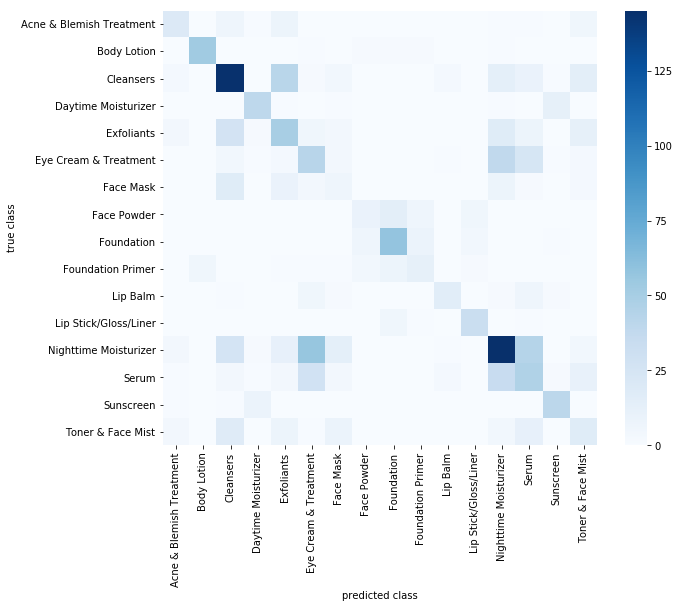

In [17]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(test_confmat, cmap='Blues')
ax.set_aspect("equal")
plt.show()

In [18]:
for i, (idx, row) in enumerate(test_confmat.iterrows()):
    accuracy = row[idx] / y_test[:,i].sum()
    print ("true class:", idx)
    print ("accuracy: %.3f"%accuracy)
    confused_class = row.sort_values(ascending=False).drop(idx).iloc[:3].index.values
    print ("top miss predictions:", confused_class, '\n')

true class: Acne & Blemish Treatment
accuracy: 0.571
top miss predictions: ['Exfoliants' 'Cleansers' 'Toner & Face Mist'] 

true class: Body Lotion
accuracy: 0.869
top miss predictions: ['Foundation Primer' 'Foundation' 'Face Powder'] 

true class: Cleansers
accuracy: 0.823
top miss predictions: ['Exfoliants' 'Toner & Face Mist' 'Nighttime Moisturizer'] 

true class: Daytime Moisturizer
accuracy: 0.800
top miss predictions: ['Sunscreen' 'Nighttime Moisturizer' 'Face Mask'] 

true class: Exfoliants
accuracy: 0.532
top miss predictions: ['Cleansers' 'Nighttime Moisturizer' 'Toner & Face Mist'] 

true class: Eye Cream & Treatment
accuracy: 0.489
top miss predictions: ['Nighttime Moisturizer' 'Serum' 'Cleansers'] 

true class: Face Mask
accuracy: 0.163
top miss predictions: ['Cleansers' 'Exfoliants' 'Nighttime Moisturizer'] 

true class: Face Powder
accuracy: 0.455
top miss predictions: ['Foundation' 'Foundation Primer' 'Lip Stick/Gloss/Liner'] 

true class: Foundation
accuracy: 0.866
top 

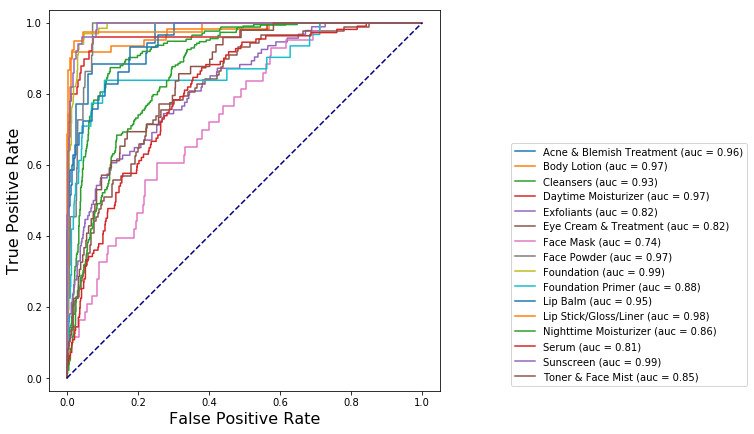

In [19]:
auc_final = report_auc_by_class(y_test, y_test_pred_proba, mlb.classes_)

Compare the auc scores for baseline (BernoulliNB) model and final model.

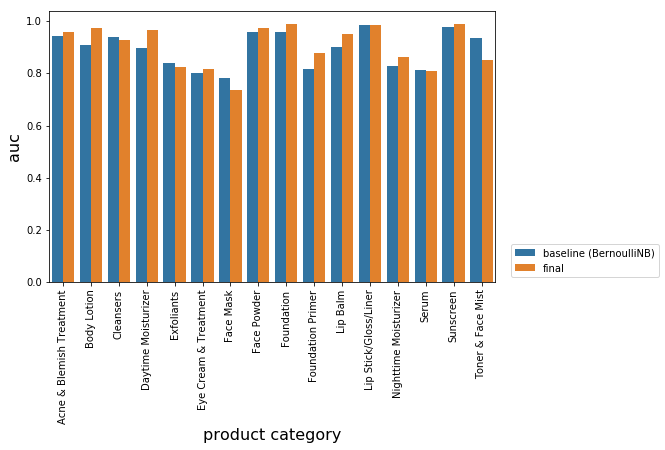

In [20]:
plt.figure(figsize=(8,5))
auc_bNB_df = pd.DataFrame({'category':mlb.classes_,'auc':auc_bNB,'label':'baseline (BernoulliNB)'})
auc_final_df = pd.DataFrame({'category':mlb.classes_,'auc':auc_final,'label':'final'})
auc_df = auc_bNB_df.append(auc_final_df)
sns.barplot(x='category', y='auc', hue='label', data=auc_df)
plt.xticks(rotation=90)
plt.xlabel('product category', fontsize=16)
plt.ylabel('auc', fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(1.2,0))
plt.show()

After stacking, the Hamming score on test set improves from 0.36 to 0.51. We also improved the auc score of 10 product categories. There are five categories that our more complicated model cannot beat naive bays: cleansers, exfoliants, face mask, serum and toner.

Overall, the results do agree with our life experience. The model gets confused on similar categories. For example, daytime moisturizers often have sunscreen ingredients in it, so sometimes our model cannot distiguish sunscreens and daytime moisturizer. Nighttime moisturizer, eye creams and serum are another group that our model get confused a lot --- in real life, they are all products that are supposed boost hydration and may have some special functions such as anti-aging, reduce hyperpigmentation... It is interesting to see that face masks got confused with cleansers, Exfoliants, and nighttime moisturizer. This is because there are typically two types of face masks: cleansing mask, which may have similar ingredient like cleansers and exfoliants. Another is the so called "sleeping mask", which you can wear overnight, they are typically like a heavy nighttime moisturizer.

One limitation of our model is that we didn't quite consider the quantity of ingredients. If we have that information, we can probably do better on toner & face mist, because although the ingredients in toner may look similar as in other products, toners usually contains much more water than other categories.

#### Examples of miss-predicted face masks

* Clinique Moisture Surge™ Overnight Mask
[clinique.com](https://www.clinique.com/product/14706/24569/skin-care/masks/moisture-surge-overnight-mask?gclid=CjwKCAjw39reBRBJEiwAO1m0OVFl9Wm4Twl06ADx6fvEDT1Clz9KC6vC9SC9RaMHB1u5YWXHUG9AxRoC25IQAvD_BwE&gclsrc=aw.ds)
[beautypedia](https://www.beautypedia.com/products/moisture-surge-overnight-mask/?archive_search=%2Fskin-care%2Fface-mask-reviews%2F%3Fskincare_group%5B0%5D%3Dface-mask-reviews%26brand_group%5B0%5D%3Dclinique)
* Clinique Pep-Start Double Bubble Purifying Mask
[clinique.com](https://www.clinique.com/product/14706/45672/skin-care/masks/clinique-pep-start-double-bubble-purifying-mask)
[beautypedia](https://www.beautypedia.com/products/pep-start-double-bubble-purifying-mask/?archive_search=%2Fskin-care%2Fface-mask-reviews%2F%3Fskincare_group%5B0%5D%3Dface-mask-reviews%26brand_group%5B0%5D%3Dclinique)

product_name: Moisture Surge™ Overnight Mask
brand: Clinique
category: {'Face Mask'}
size: 3.40 fl. oz.
price: 34.5
ingredient: Water,  Glycerin,  Cetyl Alcohol,  Dimethicone,  Glyceryl Polymethacrylate,  Butyrospermum Parkii (Shea Butter),  Cetyl Ethylhexanoate,  PEG-8,  Glycereth-28,  Sucrose,  Sorbitan Stearate,  PEG-100 Stearate,  Trehalose,  Mangifera Indica (Mango) Seed Butter,  Hypnea Musciformis (Algae) Extract,  Gellidiela Acerosa (Algae) Extract,  Olea Europaea (Olive) Fruit Extract,  Triticum Vulgare (Wheat Bran) Extract,  Cladosiphon Okamuranus Extract,  Astrocaryum Murumuru Seed Butter,  Cetearyl Alcohol,  Aloe Barbadensis Leaf Water,  PEG-75,  Caffeine,  Pantethine,  Sorbitol,  Butylene Glycol,  Oryzanol,  Bisabolol,  Panthenol,  Phytosterols,  Tocopheryl Acetate,  Caprylyl Glycol,  Sodium Hyaluronate,  Hexylene Glycol,  Carbomer,  Potassium Hydroxide,  Dextrin,  Disodium EDTA,  Phenoxyethanol,  Red 4,  Yellow 5
predicted_classes: ['Eye Cream & Treatment' 'Nighttime Moist

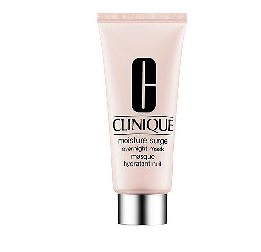

In [21]:
product = df_test.loc[df['product_names']=='Moisture Surge™ Overnight Mask']
print_product(product, '../web_scraper/images/skin_care/Moisture-Surge™-Overnight-Mask_Clinique.jpg')
idx = product.index.values[0]
k = df_test.index.get_loc(idx)
prediction = model.predict(X_test[k].reshape(1,-1))
predicted_classes = mlb.classes_[np.where(prediction==1)[1]]
print("predicted_classes:", predicted_classes)

product_name: Pep-Start Double Bubble Purifying Mask
brand: Clinique
category: {'Face Mask'}
size: 1.70 fl. oz.
price: 24.5
ingredient: Water,  Disiloxane,  Cocamidopropyl Betaine,  Sodium Cocoyl Isethionate,  Decyl Glucoside,  Glycerin,  Pentylene Glycol,  Acrylates Copolymer,  Sodium Chloride,  Morus Nigra (Mulberry) Root Extract,  Scutellaria Baicalensis Root Extract,  Vitis Vinifera (Grape) Fruit Extract,  Palmitoyl Tetrapeptide-7,  Palmitoyl Tripeptide-1,  Acetyl Glucosamine,  PEG-6 Caprylic/Capric Glycerides,  Ethylhexylglycerin,  Butylene Glycol,  Polysorbate 20,  PEG-150 Pentaerythrityl Tetrastearate,  Potassium Hydroxide,  Coconut Acid (Coconut Derived),  Acrylates/C10-30 Alkyl Acrylate Crosspolymer,  Carbomer,  Xanthan Gum,  Disodium EDTA,  Phenoxyethanol,  Red 33
predicted_classes: ['Cleansers']


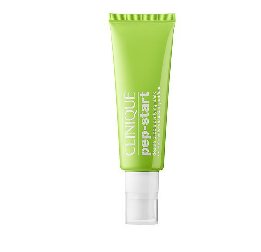

In [22]:
product = df_test.loc[df['product_names']=="Pep-Start Double Bubble Purifying Mask"]
print_product(product, '../web_scraper/images/skin_care/Pep-Start-Double-Bubble-Purifying-Mask_Clinique.jpg')
idx = product.index.values[0]
k = df_test.index.get_loc(idx)
prediction = model.predict(X_test[k].reshape(1,-1))
predicted_classes = mlb.classes_[np.where(prediction==1)[1]]
print("predicted_classes:", predicted_classes)